## Implement the Problem

After having formulated the problem the right way, we can start implementing it. In this tutorial we use the element-wise problem definition, which is one out of three different ways for implementing a problem. We define a new Python objective inheriting from ElementwiseProblem and set the correct attributes, such as the number of objectives (n_obj) and constraints (n_constr) and the lower (xl) and upper bounds (xu). The function being responsible for the evaluation is _evaluate which shall be implemented next. The function’s interface is the parameters x and out. For this element-wise implementation x is a one-dimensional NumPy array of length n_var which represents a single solution to be evaluated. The output is supposed to be written to the dictionary out. The objective values should be written to out["F"] as a list of NumPy array with length of n_obj and the constraints to out["G"] with length of n_constr (if the problem has constraints to be satisfied at all).

In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_ieq_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()

## Initialize an Algorithm

The reason why you became aware of this framework, is probably the existence of an algorithm you like to use. pymoo follows an object oriented approach and, thus, we have to define an algorithm object next. Depending on the optimization problem, different algorithms will perform better or worse on different kind of problems. It is recommendable to first understand the intuition behind an algorithm and then select one which seems to be most suitable for solving your optimization problem. A list of algorithms which are available in pymoo is available here.

In our case, the optimization problem is rather simple, but the aspect of having two objectives and two constraints should be considered. Thus, let us select the well-known multi-objective algorithm NSGA-II. For the majority of algorithms you could either choose the default hyper-parameters or create your own version of the algorithm by modifying them. For instance, for this relatively simple problem we choose a population size of 40 (pop_size=40) and with only 10 (n_offsprings=10) in each generation. Such an implementation is a greedier variant and improves the convergence of simpler optimization problems without major difficulties regarding optimization, such as the existence of local Pareto-fronts. Moreover, we enable a duplicate check (eliminate_duplicates=True), making sure that the mating produces offsprings that are different from themselves and the existing population regarding their design space values.

In [2]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)


The algorithm object contains an implementation of NSGA-II with the custom configuration discussed above. The object can now be used to start an optimization run.

## Define a Termination Criterion
Furthermore, a termination criterion needs to be defined to start the optimization procedure. Most common ways of defining the termination is by limiting the overall number of function evaluations or simply the number of iterations of the algorithm. Moreover, some algorithms already have implemented their own, for instance Nelder-Mead when the simplex becomes degenerated or CMA-ES where a vendor library is used. Because of the simplicity of this problem we use a rather small number of 40 iteration of the algorithm.

In [3]:
from pymoo.termination import get_termination

termination = get_termination("n_gen", 40)

You can find a list and explanations of termination criteria available in pymoo https://pymoo.org/interface/termination.html. If no termination criteria is defined, then the progress in the design and objective space will kept track of in each iteration. When no significant progress has been made (this is the art of defining what that shall be), the algorithm terminates.

## Optimize
Finally, we are solving the problem with the algorithm and termination we have defined. The functional interface uses the minimize method. By default, the minimize performs deep-copies of the algorithm and the termination object which guarantees they are not modified during the function call. This is important to ensure that repetitive function calls with the same random seed end up with the same results. When the algorithm has been terminated, the minimize function returns a Result (https://pymoo.org/interface/result.html) object.

In [4]:
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.000000E+00 |  2.363992E+01 |             - |             -
     2 |       50 |      1 |  0.000000E+00 |  1.239636E+01 |  0.000000E+00 |             f
     3 |       60 |      2 |  0.000000E+00 |  5.4620972973 |  1.0000000000 |         ideal
     4 |       70 |      2 |  0.000000E+00 |  2.3938570636 |  0.000000E+00 |             f
     5 |       80 |      2 |  0.000000E+00 |  1.1200787779 |  0.000000E+00 |             f
     6 |       90 |      3 |  0.000000E+00 |  0.1858089725 |  0.1785481247 |             f
     7 |      100 |      4 |  0.000000E+00 |  0.0096392745 |  0.0639961700 |         ideal
     8 |      110 |      5 |  0.000000E+00 |  0.0016302512 |  0.0912676400 |         ideal
     9 |      120 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1217555949 |         ideal
    10 |      130 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0038809178 |             f

If the verbose=True, some printouts during the algorithm’s execution are provided. This can very from algorithm to algorithm. Here, we execute NSGA2 on a problem where pymoo has no knowledge about the optimum. Each line represents one iteration. The first two columns are the current generation counter and the number of evaluations so far. For constrained problems, the next two columns show the minimum constraint violation (cv (min)) and the average constraint violation (cv (avg)) in the current population. This is followed by the number of non-dominated solutions (n_nds) and two more metrics which represents the movement in the objective space.

## Visualize

Analyzing the solutions being found by the algorithm is vital. Always a good start is visualizing the solutions to get a grasp of commonalities or if the Pareto-front is known to even check the convergence.

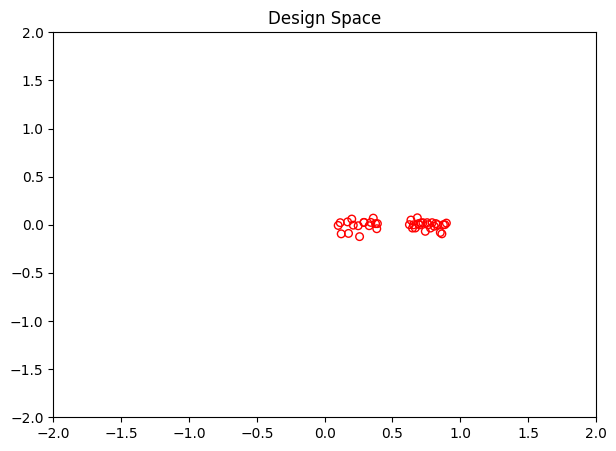

In [5]:
import matplotlib.pyplot as plt
xl, xu = problem.bounds()
plt.figure(figsize=(7, 5))
plt.scatter(X[:, 0], X[:, 1], s=30, facecolors='none', edgecolors='r')
plt.xlim(xl[0], xu[0])
plt.ylim(xl[1], xu[1])
plt.title("Design Space")
plt.show()

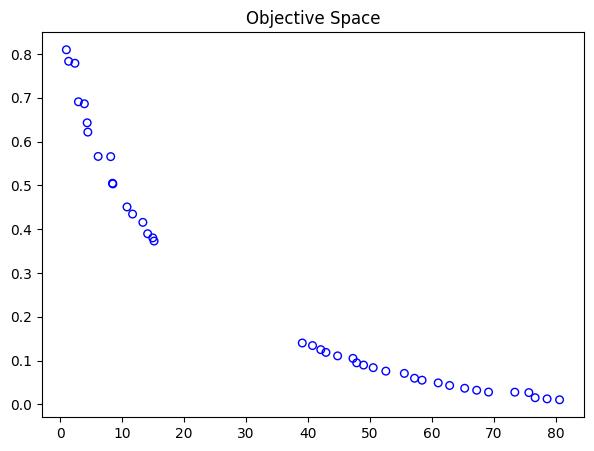

In [6]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

## Part IV: Analysis of Convergence
Great! So far, we have executed an algorithm and already obtained a solution set. But let us not stop here without knowing how the algorithm has performed. This will also answer how we should define a termination criterion if we solve the problem again. The convergence analysis shall consider two cases, i) the Pareto-front is not known, or ii) the Pareto-front has been derived analytically, or a reasonable approximation exists.

## Result
To further check how close the results match the analytically derived optimum, we have to convert the objective space values to the original definition where the second objective f2
 was maximized. Plotting then the Pareto-front shows how close the algorithm was able to converge.

In [7]:
from pymoo.util.misc import stack

class MyTestProblem(MyProblem):

    def _calc_pareto_front(self, flatten=True, *args, **kwargs):
        f2 = lambda f1: ((f1/100) ** 0.5 - 1)**2
        F1_a, F1_b = np.linspace(1, 16, 300), np.linspace(36, 81, 300)
        F2_a, F2_b = f2(F1_a), f2(F1_b)

        pf_a = np.column_stack([F1_a, F2_a])
        pf_b = np.column_stack([F1_b, F2_b])

        return stack(pf_a, pf_b, flatten=flatten)

    def _calc_pareto_set(self, *args, **kwargs):
        x1_a = np.linspace(0.1, 0.4, 50)
        x1_b = np.linspace(0.6, 0.9, 50)
        x2 = np.zeros(50)

        a, b = np.column_stack([x1_a, x2]), np.column_stack([x1_b, x2])
        return stack(a,b, flatten=flatten)

problem = MyTestProblem()

For IGD, the Pareto front needs to be known or to be approximated. In our framework, the Pareto front of test problems can be obtained by:

In [8]:
pf_a, pf_b = problem.pareto_front(use_cache=False, flatten=False)

pf = problem.pareto_front(use_cache=False, flatten=True)

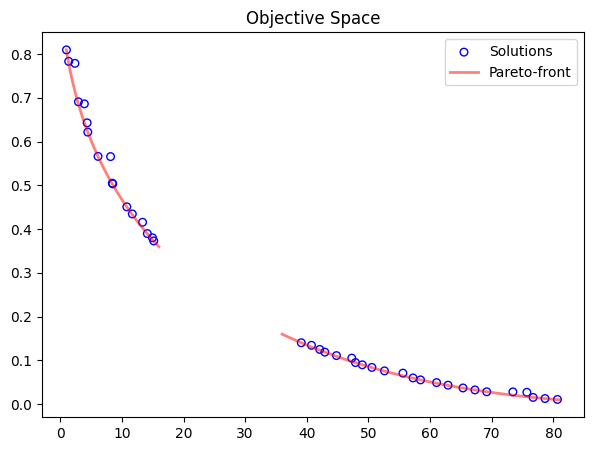

In [9]:
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='b', label="Solutions")
plt.plot(pf_a[:, 0], pf_a[:, 1], alpha=0.5, linewidth=2.0, color="red", label="Pareto-front")
plt.plot(pf_b[:, 0], pf_b[:, 1], alpha=0.5, linewidth=2.0, color="red")
plt.title("Objective Space")
plt.legend()
plt.show()